In [1]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense,  Dropout, Input, LSTM, Embedding,SpatialDropout1D, BatchNormalization, Flatten, LayerNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow_text as text

import pandas_tfrecords as pdtfr

import matplotlib.pyplot as plt
import re

from pathlib import Path

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import pickle
from sklearn.metrics import confusion_matrix

import keras_tuner as kt
import seaborn as sns
import tensorflow_datasets as tfds


tf.random.set_seed(0)
np.random.seed(0)
stop_words_list = stopwords.words('english') 

#tf.config.run_functions_eagerly(True)
#import tensorflow_data_validation as tfdv
#tf.debugging.set_log_device_placement(True)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

from sklearn.model_selection import train_test_split
import keras_nlp
from transformers import  RobertaTokenizer, TFRobertaModel



2024-07-30 15:16:50.794203: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-30 15:16:50.824906: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-30 15:16:51.308712: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-07-30 15:16:52.036894: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/t

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14356425161589556262
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 21906718720
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7098364477118495486
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


[nltk_data] Downloading package stopwords to /home/n/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/home/n/anaconda3/envs/AI_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-30 15:16:52.739860: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-30 15:16:52.741806: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/

Num GPUs Available:  1


# Read dataset


In [2]:
dataset, info = tfds.load('imdb_reviews', with_info=True, 
                          as_supervised=True)

train_dataset, test_dataset = dataset['train'], dataset['test']
train_dataset

2024-07-30 15:16:53.089328: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-30 15:16:53.091957: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-30 15:16:53.093446: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [3]:
for i, o in train_dataset.take(1):
    print(i.shape, o.shape)
    print(i, o)

() ()
tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string) tf.Tensor(0, shape=(), dtype=int64)


2024-07-30 15:16:53.439598: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-07-30 15:16:53.440297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
def convert_tfdataframe_to_pddataframe(tf_df):
    data_list = []
    for i, (features, label) in enumerate(tf_df):
        
        if i % 5000 == 0 : print(f"{i}/{len(tf_df)}")
        
        data_list.append((features.numpy().decode('utf-8'), label.numpy()))

    # Create a Pandas DataFrame
    return pd.DataFrame(data_list, columns = [ "review", "sentiment"])

# Create a Pandas DataFrame
train_dataset = convert_tfdataframe_to_pddataframe(train_dataset)
train_dataset

0/25000
5000/25000
10000/25000
15000/25000
20000/25000


2024-07-30 15:16:54.902811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


review  sentiment
0      This was an absolutely terrible movie. Don't b...          0
1      I have been known to fall asleep during films,...          0
2      Mann photographs the Alberta Rocky Mountains i...          0
3      This is the kind of film for a snowy Sunday af...          1
4      As others have mentioned, all the women that g...          1
...                                                  ...        ...
24995  I have a severe problem with this show, severa...          0
24996  The year is 1964. Ernesto "Che" Guevara, havin...          1
24997  Okay. So I just got back. Before I start my re...          0
24998  When I saw this trailer on TV I was surprised....          0
24999  First of all, Riget is wonderful. Good comedy ...          1

[25000 rows x 2 columns]

In [5]:
# Create a Pandas DataFrame
test_dataset = convert_tfdataframe_to_pddataframe(test_dataset)
test_dataset

0/25000
5000/25000
10000/25000
15000/25000
20000/25000


2024-07-30 15:16:56.490615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


review  sentiment
0      There are films that make careers. For George ...          1
1      A blackly comic tale of a down-trodden priest,...          1
2      Scary Movie 1-4, Epic Movie, Date Movie, Meet ...          0
3      Poor Shirley MacLaine tries hard to lend some ...          0
4      As a former Erasmus student I enjoyed this fil...          1
...                                                  ...        ...
24995  Feeling Minnesota is not really a road movie, ...          0
24996  This is, without doubt, one of my favourite ho...          1
24997  Most predicable movie I've ever seen...extreme...          0
24998  It's exactly what I expected from it. Relaxing...          1
24999  They just don't make cartoons like they used t...          1

[25000 rows x 2 columns]

# Check statistics

In [6]:
train_dataset.dtypes

review       object
sentiment     int64
dtype: object

In [7]:
# # Instantiate a StatsOptions class and define the feature_allowlist property
# stats_options = tfdv.StatsOptions(
#     feature_allowlist=train_dataset.columns.tolist(),
#     enable_semantic_domain_stats= True # Because we are processing text
#     )
# stats_options

In [8]:
# train_stats = tfdv.generate_statistics_from_dataframe(train_dataset, stats_options) 

# # get the number of features used to compute statistics
# print(f"Number of features used: {len(train_stats.datasets[0].features)}")

# # check the number of examples used
# print(f"Number of examples used: {train_stats.datasets[0].num_examples}")

# # check the column names of the first and last feature
# print(f"First feature: {train_stats.datasets[0].features[0].path.step[0]}")
# print(f"Last feature: {train_stats.datasets[0].features[-1].path.step[0]}")
# tfdv.visualize_statistics(train_stats)


# Set Parameters

In [9]:
batch_size=128

ETL_STOPWORDS= False
PREPARE_TRAINIG_DATA= False
TRAIN_MODE= True

TUNNING = True
INFERENCE_MODE = True

threshold = 1
classN=1
min_freq = 4



In [10]:

DATA_CHECKPOINTS_DIR = './checkpoints'
tfrecord_filename = "train_tmp.tfrecord"
train_tmp_record_path = f'{DATA_CHECKPOINTS_DIR}/{tfrecord_filename}'

!mkdir -p {DATA_CHECKPOINTS_DIR}



# Set Functions to perform data cleaning and feature engineering

In [11]:
def check_word_frequency(train_df):
    
    print("Dataset lentgh : ",len(train_df))

    tokenizer = Tokenizer(filters='!"#$%&()*+,-/:;=?@[\\]^_´`«»{|}~\t\n\'',oov_token='<oov>')# sequence_size = 500 ~= mean+ std sentence size
    tokenizer.fit_on_texts(train_df.review.values.tolist())

    word_frequency = {}
    for i, (word, count) in enumerate(tokenizer.word_counts.items()):
        word_frequency[word]=count
            
    return word_frequency


def update_stop_words(word_frequency, freq,max_freq,stop_word):
 
    it = 0
    for word, count in word_frequency.items():
        if count < freq:
            if it < 10:
                print(word)
                it +=1
            stop_word.append(word)
        elif count >max_freq :
            stop_word.append(word)
            
    return list(set(stop_word))


word_frequency= check_word_frequency(train_dataset)
max_freq = np.max(list(word_frequency.values())) +1 
# Update stop words list with the less frequent 
updated_stop_word = update_stop_words(word_frequency, min_freq, max_freq, stop_words_list.copy())

Dataset lentgh :  25000
ironside.
revolutions.
sette
accord
gunfighters
>canadian
paddle
symptoms.
barometers
microscopically


In [12]:
len(updated_stop_word)/len(word_frequency)

0.6626352641629535

In [13]:

def limit_words_tf(review, sentiment):
    # Split the string into tokens
    tokens = tf.strings.split(review)

    # Limit the number of tokens to max_words
    limited_tokens = tokens[:sequence_size]
    
    # Join the tokens back into a string
    limited_review = tf.strings.reduce_join(limited_tokens, separator=' ')
        
    return limited_review, sentiment



def save_record(dataset, record_path):

    with tf.io.TFRecordWriter(record_path) as writer:
        for index, row in dataset.iterrows():
            input_ids, attention_mask, sentiment = row["input_ids"], row["attention_mask"], row["sentiment"]
            # Serialize example
            feature = {
                'input_ids': tf.train.Feature(int64_list=tf.train.Int64List(value=input_ids)),  # List feature
                'attention_mask': tf.train.Feature(float_list=tf.train.FloatList(value=attention_mask)), # List feature
                'sentiment': tf.train.Feature(int64_list=tf.train.Int64List(value=[sentiment])) # Single value feature
            }
            example_proto = tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()
            
            writer.write(example_proto)

def clean_reviews(review, sentiment):
    
    lowercase = tf.strings.lower(review)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    
    tokens = tf.strings.split(stripped_html)
    # Filter out words to remove
    words_to_remove_tensor = tf.constant(updated_stop_word)
    mask = tf.logical_not(tf.reduce_any(tf.equal(tokens, words_to_remove_tensor[:, tf.newaxis]), axis=0))
    
    # Filter out words to remove
    filtered_tokens = tf.boolean_mask(tokens, mask)
    
    # Join the remaining tokens back into a string
    processed_data = tf.strings.reduce_join(filtered_tokens, separator=' ')
    
    sentence_size = len(tf.strings.split(processed_data))
    return (processed_data, sentiment , sentence_size)
    
def process_stop_words(td_dataset):

    # Convert to tf.dataset
    td_dataset = tf.data.Dataset.from_tensor_slices((td_dataset['review'], td_dataset['sentiment']))

    for i, o in td_dataset.take(1):
        print(i.shape, o.shape)
        print("Pre processed ds : ",i, o )
   
    
    td_dataset = td_dataset.map(clean_reviews, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    for i, o, l in td_dataset.take(3):
        print("Post processed ds : ",l, o, i )
        
    data_list_element = []
    total_len = len(td_dataset)

    print(f"Starting Extraction in batches {total_len} ...")
    for i, (features, label, size) in enumerate(td_dataset.take(total_len)):
        if i % 1000 == 0 : print(f"{i}/{total_len}")
        
        data_list_element.append((features.numpy(), label.numpy(), size.numpy()))
    
    print("Creating dataframe....")
    return pd.DataFrame(data_list_element, columns = [ "review", "sentiment", "size"])

if ETL_STOPWORDS:
    train_ds = process_stop_words(train_dataset)
    train_ds.to_pickle(f"{DATA_CHECKPOINTS_DIR}/train_ds.pkl")  
    
    display(train_ds)
    test_ds  = process_stop_words(test_dataset)
    test_ds.to_pickle(f"{DATA_CHECKPOINTS_DIR}/test_ds.pkl") 
    display(test_ds) 
else:
    train_ds = pd.read_pickle(f"{DATA_CHECKPOINTS_DIR}/train_ds.pkl")  
    test_ds = pd.read_pickle(f"{DATA_CHECKPOINTS_DIR}/test_ds.pkl") 



In [14]:
train_ds.review = train_ds.review.apply(lambda x : x.decode("utf-8"))
test_ds.review = test_ds.review.apply(lambda x : x.decode("utf-8"))

In [15]:
if ETL_STOPWORDS:

    with open(f'{DATA_CHECKPOINTS_DIR}/word_frequency.pkl', 'wb') as f:
        pickle.dump(word_frequency, f)

    with open(f'{DATA_CHECKPOINTS_DIR}/updated_stop_word.pkl', 'wb') as f:
        pickle.dump(updated_stop_word, f)

else:
    
    with open(f'{DATA_CHECKPOINTS_DIR}/word_frequency.pkl', 'rb') as f:
        word_frequency = pickle.load(f)
        
    with open(f'{DATA_CHECKPOINTS_DIR}/updated_stop_word.pkl', 'rb') as f:
        updated_stop_word = pickle.load(f)

        


# Check sentence size
 

In [16]:
train_ds["size"].describe()

count    25000.000000
mean       122.220720
std         92.135317
min          4.000000
25%         65.000000
50%         90.000000
75%        149.000000
max       1395.000000
Name: size, dtype: float64

In [17]:
train_ds[train_ds["size"] > 800].review.values[0]

'match 1: tag team table match bubba ray spike dudley vs eddie guerrero chris benoit bubba ray spike dudley started things tag team table match eddie guerrero chris according rules match, opponents go tables order get win. benoit guerrero heated early taking turns hammering first spike bubba ray. german benoit bubba took wind dudley brother. spike tried help brother, referee restrained benoit guerrero corner. benoit stomping away bubba, guerrero set table outside. spike dashed ring top rope onto guerrero outside! recovering taking care spike, guerrero slipped table ring helped wolverine set up. tandem set double superplex middle rope would put bubba table, spike knocked table right brother came crashing down! guerrero benoit propped another table corner tried irish whip spike it, bubba dashed blocked brother. bubba caught fire lifted opponents back body drops! bubba slammed guerrero spike stomped wolverine top rope. bubba held benoit bay spike soar wassup! headbutt! shortly after, beno

count    25000.000000
mean       120.193120
std         90.088172
min          3.000000
25%         65.000000
50%         90.000000
75%        146.000000
max       1183.000000
Name: size, dtype: float64

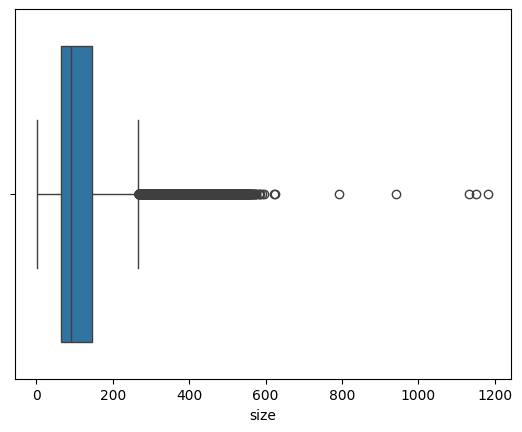

In [18]:
sns.boxplot(x=test_ds['size'])
test_ds["size"].describe()

Finding the outliers to fix the sentence size . Every sample with size considered as outlier will be trimmed

In [19]:

Q1_train = train_ds["size"].quantile(0.25)
Q3_train = train_ds["size"].quantile(0.75)
IQR_train = Q3_train - Q1_train
print("Train Q1_train : ",Q1_train)
print("Train Q3_train : ",Q3_train)
print("Train IQR : ",IQR_train)
print("Final training dataset size : ",(Q1_train - 1.5 * IQR_train),(Q3_train + 1.5 * IQR_train), len(train_ds[ train_ds["size"] <= (Q3_train + 1.5 * IQR_train)]))
print("Training data to be trimed : ",len(train_ds[ train_ds["size"] > (Q3_train + 1.5 * IQR_train)]))


Train Q1_train :  65.0
Train Q3_train :  149.0
Train IQR :  84.0
Final training dataset size :  -61.0 275.0 23199
Training data to be trimed :  1801


In [20]:
Q1_test = test_ds["size"].quantile(0.25)
Q3_test = test_ds["size"].quantile(0.75)
IQR_test = Q3_test - Q1_test

print("Test IQR : ",IQR_test)
print("Final testing dataset size : ",(Q1_test - 1.5 * IQR_test),(Q3_test + 1.5 * IQR_test), len(test_ds[ test_ds["size"] <= (Q3_test + 1.5 * IQR_test)]))
print("Testing data to be trimed : ",len(test_ds[ test_ds["size"] > (Q3_test + 1.5 * IQR_test)]))


Test IQR :  81.0
Final testing dataset size :  -56.5 267.5 23137
Testing data to be trimed :  1863


Apply the sentence cut

In [21]:
IQR_total = np.maximum((Q3_train + 1.5 * IQR_train),(Q3_test + 1.5 * IQR_test))
sequence_size = int(IQR_total)
sequence_size

275

In [22]:
test_ds = test_ds[test_ds['size'] > 0] 
train_ds = train_ds[train_ds['size'] > 0] 

In [23]:

def limit_words(review):
    # Split the string into tokens
    tokens = review.split()

    # Limit the number of tokens to max_words
    limited_tokens = tokens[:sequence_size]
    
    # Join the tokens back into a string
    limited_review = ' '.join(limited_tokens)
        
    return limited_review

print("Cleaning training dataset - sentences size processing ")
train_ds["cleaned_review"] = train_ds.review.apply(lambda x : limit_words(x)) 
train_ds["cleaned_size"] = train_ds.cleaned_review.apply(lambda x : len(x.split())) 

print("Cleaning testing dataset - sentences size processing ")
test_ds["cleaned_review"] = test_ds.review.apply(lambda x : limit_words(x)) 
test_ds["cleaned_size"] = test_ds.cleaned_review.apply(lambda x : len(x.split())) 

num_labels = len(train_ds.sentiment.unique())  # number of labels for your classification task

display(train_ds)
display(test_ds)

Cleaning training dataset - sentences size processing 
Cleaning testing dataset - sentences size processing 


review  sentiment  size  \
0      absolutely terrible movie. lured christopher w...          0    65   
1      known fall asleep films, usually due combinati...          0    52   
2      mann photographs alberta rocky mountains super...          0    75   
3      kind film snowy sunday afternoon rest world go...          1    45   
4      others mentioned, women go nude film mostly ab...          1    40   
...                                                  ...        ...   ...   
24995  severe problem show, several actually. simple ...          0   266   
24996  year ernesto "che" guevara, cuban citizen last...          1    95   
24997  okay. got back. start review, let tell one thi...          0   394   
24998  saw trailer tv surprised. may 2008 six flags n...          0    78   
24999  first all, riget wonderful. good comedy myster...          1   162   

                                          cleaned_review  cleaned_size  
0      absolutely terrible movie. lured christopher w...            65  
1      known fall asleep films, usually due combinati...            52  
2      mann photographs alberta rocky mountains super...            75  
3      kind film snowy sunday afternoon rest world go...            45  
4      others mentioned, women go nude film mostly ab...            40  
...                                                  ...           ...  
24995  severe problem show, several actually. simple ...           266  
24996  year ernesto "che" guevara, cuban citizen last...            95  
24997  okay. got back. start review, let tell one thi...           275  
24998  saw trailer tv surprised. may 2008 six flags n...            78  
24999  first all, riget wonderful. good comedy myster...           162  

[25000 rows x 5 columns]

review  sentiment  size  \
0      films make careers. george romero, night livin...          1    89   
1      comic tale down-trodden priest, nazarin showca...          1   159   
2      scary movie 1-4, epic movie, date movie, meet ...          0   301   
3      poor shirley maclaine tries hard lend gravitas...          0   146   
4      former student enjoyed film much. realistic fu...          1    38   
...                                                  ...        ...   ...   
24995  feeling minnesota really road movie, that's st...          0    99   
24996  is, without doubt, one favourite horror films ...          1   158   
24997  predicable movie i've ever seen...extremely bo...          0    91   
24998  exactly expected it. relaxing, humorous entert...          1    42   
24999  make cartoons like used to. one wit, great cha...          1    32   

                                          cleaned_review  cleaned_size  
0      films make careers. george romero, night livin...            89  
1      comic tale down-trodden priest, nazarin showca...           159  
2      scary movie 1-4, epic movie, date movie, meet ...           275  
3      poor shirley maclaine tries hard lend gravitas...           146  
4      former student enjoyed film much. realistic fu...            38  
...                                                  ...           ...  
24995  feeling minnesota really road movie, that's st...            99  
24996  is, without doubt, one favourite horror films ...           158  
24997  predicable movie i've ever seen...extremely bo...            91  
24998  exactly expected it. relaxing, humorous entert...            42  
24999  make cartoons like used to. one wit, great cha...            32  

[25000 rows x 5 columns]

Before thinking on trimming, we must check if any important sentiment information will not be deleted.

# Tokenize and prepare embeddings

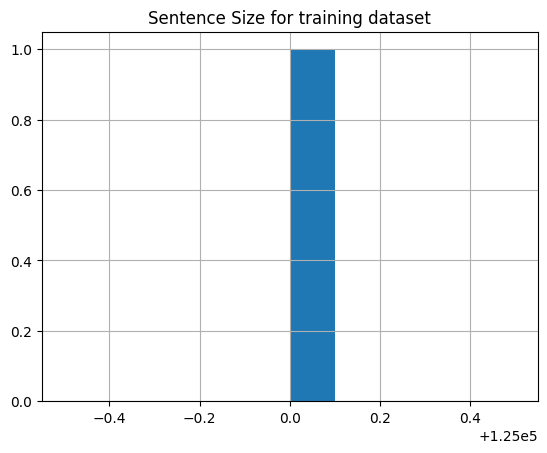

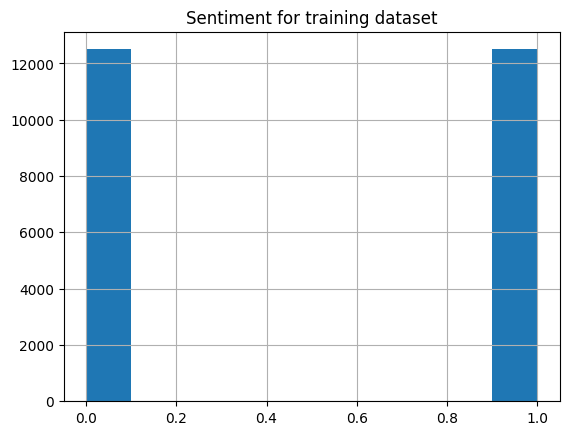

count         1.0
mean     125000.0
std           NaN
min      125000.0
25%      125000.0
50%      125000.0
75%      125000.0
max      125000.0
dtype: float64


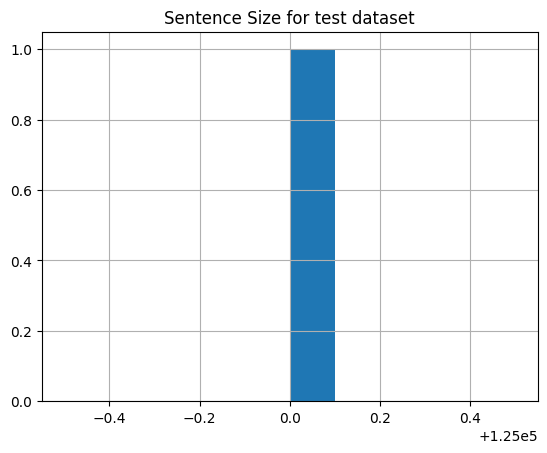

count         1.0
mean     125000.0
std           NaN
min      125000.0
25%      125000.0
50%      125000.0
75%      125000.0
max      125000.0
dtype: float64


In [24]:
plt.figure()
pd.Series(train_ds.size).hist(bins=10)
plt.title("Sentence Size for training dataset")

plt.figure()
pd.Series(train_ds.sentiment).hist()
plt.title("Sentiment for training dataset")

plt.show()
print(pd.Series(train_ds.size).describe())

plt.figure()
pd.Series(test_ds.size).hist()
plt.title("Sentence Size for test dataset")

plt.figure()
pd.Series(test_ds.sentiment).hist()
plt.title("Sentiment for test dataset")

plt.show()
print(pd.Series(test_ds.size).describe())

In [25]:
train_ds = train_ds[["cleaned_review","sentiment"]]
test_ds = test_ds[["cleaned_review","sentiment"]]
train_ds.sentiment = train_ds.sentiment.astype("int8")
test_ds.sentiment = test_ds.sentiment.astype("int8")

display(train_ds)
display(test_ds)

cleaned_review  sentiment
0      absolutely terrible movie. lured christopher w...          0
1      known fall asleep films, usually due combinati...          0
2      mann photographs alberta rocky mountains super...          0
3      kind film snowy sunday afternoon rest world go...          1
4      others mentioned, women go nude film mostly ab...          1
...                                                  ...        ...
24995  severe problem show, several actually. simple ...          0
24996  year ernesto "che" guevara, cuban citizen last...          1
24997  okay. got back. start review, let tell one thi...          0
24998  saw trailer tv surprised. may 2008 six flags n...          0
24999  first all, riget wonderful. good comedy myster...          1

[25000 rows x 2 columns]

cleaned_review  sentiment
0      films make careers. george romero, night livin...          1
1      comic tale down-trodden priest, nazarin showca...          1
2      scary movie 1-4, epic movie, date movie, meet ...          0
3      poor shirley maclaine tries hard lend gravitas...          0
4      former student enjoyed film much. realistic fu...          1
...                                                  ...        ...
24995  feeling minnesota really road movie, that's st...          0
24996  is, without doubt, one favourite horror films ...          1
24997  predicable movie i've ever seen...extremely bo...          0
24998  exactly expected it. relaxing, humorous entert...          1
24999  make cartoons like used to. one wit, great cha...          1

[25000 rows x 2 columns]

In [26]:

train_ds, val_ds = train_test_split(train_ds,test_size=0.2,train_size=0.8)
display(train_ds)
display(val_ds)

cleaned_review  sentiment
10263  show possibly biggest, ugliest, generic steam ...          0
18409  henry thomas "great". character held attention...          1
13047  future awaits us? overpopulated, unforgiving w...          1
21371  rated basic instinct 2 high, yet movie got les...          0
16392  well, people would say particular movie hey! t...          1
...                                                  ...        ...
13123  horrible ending - can't believe moore spent ye...          0
19648  watched movie three times. last time, kept ski...          1
9845   rented film yesterday mostly due good-looking ...          0
10799  young mr. lincoln marks first film director/st...          1
2732   dwight frye steals show one foolish young man(...          1

[20000 rows x 2 columns]

cleaned_review  sentiment
14149  ghost story,(the new house) terrific horror st...          1
8946   "a little nonsense then, cherished men." smart...          1
22378  little, parents got movie watch. really liked ...          1
12162  connie hoffman pretty attractively topless tim...          0
4879   entertaining movie. reviews read forum written...          1
...                                                  ...        ...
4022   "foxes" great film. four young actresses jodie...          1
17601  kiera nightly moved straight p&p set action mo...          1
4718   dude, really!!!! guys past 20 years, shocking ...          0
9376   start, let say experience movie might influenc...          0
8019   think opening 20 minutes film perhaps one exci...          1

[5000 rows x 2 columns]

Saving the data to the disk to clean memory after

In [27]:
train_tfds = tf.data.Dataset.from_tensor_slices(
        (
            train_ds.cleaned_review.tolist()
        )
    ).batch(batch_size).shuffle(buffer_size=len(train_ds)).prefetch(tf.data.AUTOTUNE)
for x in train_tfds.take(1):
    print(x)

tf.Tensor(
[b'honestly, know what\'s funnier, horrific remake, comments board. masterpiece\'s review tears, that\'s funny. anyway, movie among worst movies ever, certainly bottom barrel sequels. "omen" name title made stop watch morning hbo, slap face three, especially original. many classically bad moments, favorite guy catching fire psychic fair!! good times ! movie omen series "scary movie" entire genre. avoid unless looking good laugh.'
 b'need honest. watched enjoy show gross, offensive, hilarious, yeah, lot humor tastes. kind humor deals making fun people falling skateboards, example great time it. or, enjoy people extreme stunt actions going bad, also great time. enjoy scatological humor extreme situations oh , enjoy show. enjoy three kinds humor "dirty s\xc3\xa0nchez" offers. like hard laugh situations show. "jackass" like walk park compared one. tired typical american stupidity jackass, give try english extreme stupidity show. due respect. show little taste class. recommended 

2024-07-30 15:17:00.085479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [28]:
dev_tfds = tf.data.Dataset.from_tensor_slices(
        (
            val_ds.cleaned_review.tolist(), val_ds.sentiment.tolist()
        )
    ).batch(batch_size).shuffle(buffer_size=len(val_ds)).prefetch(tf.data.AUTOTUNE)
for x in dev_tfds.take(1):
    print(x)

test_tfds = tf.data.Dataset.from_tensor_slices(
        (
            test_ds.cleaned_review.tolist(), test_ds.sentiment.tolist()
        )
    ).batch(batch_size).shuffle(buffer_size=len(test_ds)).prefetch(tf.data.AUTOTUNE)
for x in test_tfds.take(1):
    print(x)

(<tf.Tensor: shape=(512,), dtype=string, numpy=
array([b'diane keaton gave outstanding performance rather sad funny story involved quite young people deep dark secrets. diane keaton,(natalie),"the family stone",\'05, daughter loved beyond words describe. always called told her, "surrender dorothy", expression used \'wizard oz\',1939. sudden car accident occurs natalie gets deeply involved daughter\'s friends lovers. natalie investigates, truths finds real relationship daughter. great film view enjoy, especially good acting supporting actors.',
       b'though really feel anything lance\'s character, felt wife could done much better anyone else. could much stronger movie spent time character development, perhaps lance- would liked better. however, completely agree doyleluver, said "and quote glenn quinn\'s character ben: \'i\'m star it, that\'s right i\'m talented one!\'" watch movie, watch him, even he\'s background... facial expressions, eyes, know sure motivates ben, exactly feels co

2024-07-30 15:17:00.158032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(<tf.Tensor: shape=(512,), dtype=string, numpy=
array([b'1984, karate kid charm it, even little poor man\'s alas, producer jerry weintraub failed realize best leave story point ended, convinced ralph macchio pat morita make extra effort turn film trilogy. part iii definitive low franchise, yet someone must thought series still potential. explanation could possibly existence next karate kid? wait minute. next? yep, macchio\'s gone (at least smart enough stop eventually), replacement hilary swank (!), playing troubled teenager (what else?) named julie now, girl family issues. also gets trouble school. said school sadistic gym teacher (michael ironside). turns out, though, one students actually nice guy, julie falls him. gets bigger trouble before, course. lucky her, currently living mr. (morita), old friend grandfather happens know get back bad guys. factors ad seven clich\xc3\xa9s, that\'s generic plot summary - imagine detailed scenes must like! beginning end, next karate kid tired, fl

2024-07-30 15:17:00.334467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [30]:
vocab_size = len(word_frequency.keys())
vocab_size, sequence_size

(120967, 275)

In [31]:
## Train tokenizer vocabulary on training data only. Words that occur only on the test data will be unknown, and this is the expected behaviour when considering real word environment.

vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
    train_tfds,
    vocabulary_size=vocab_size,
    lowercase=True,
    reserved_tokens=["[PAD]", "[UNK]", "[BOS]", "[EOS]"],
)

#WordPieceTokenizer is an efficient implementation of the WordPiece algorithm used by BERT and other models. 
tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=vocab,
    sequence_length=sequence_size,
    lowercase=True,
)

train_tfds = tf.data.Dataset.from_tensor_slices(
        (
            train_ds.cleaned_review.tolist(), train_ds.sentiment.tolist()
        )
    ).batch(batch_size).shuffle(buffer_size=len(train_ds)).prefetch(tf.data.AUTOTUNE)
for x in train_tfds.take(1):
    print(x)

2024-07-30 15:17:08.052252: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# packer adds a start token
start_packer = keras_nlp.layers.StartEndPacker(
    sequence_length=window_size,
    start_value=tokenizer.token_to_id("[BOS]"),
    end_value = tokenizer.token_to_id("[EOS]"),
)

def preprocess(inputs,output):
    tokenized_inputs = tokenizer(inputs)
    features = start_packer(tokenized_inputs)
    return features, output

train_tfds= train_tfds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(
    tf.data.AUTOTUNE
)

dev_tfds= dev_tfds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(
    tf.data.AUTOTUNE
)


test_tfds= test_tfds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(
    tf.data.AUTOTUNE
)

print("Training set ...")
for i, o in train_tfds.take(1):
    print("input : ",i[0])
    print("output : ",o)
    print("Detokenized input: ",tokenizer.detokenize(i[0]))


print("Dev set ...")
for i, o in dev_tfds.take(1):
    print("input : ",i[0])
    print("output : ",o)
    print("Detokenized input: ",tokenizer.detokenize(i[0]))


print("Testing set ...")
for i, o in test_tfds.take(1):
    print("input : ",i[0])
    print("output : ",o)
    print("Detokenized input: ",tokenizer.detokenize(i[0]))


# Attention model training process

### Run training process 


In [ ]:
class AttentionSentimentModel(tf.keras.Model):
    def __init__(
        self, 
        n_classes = 1,
        vocab_len = vocab_len, 
        window_size = window_size, 
        embedding_dim = embedding_dim,  
        num_att_layers = 1, 
        n_attention_head = 2, 
        feed_forward_dim = [128],
        dropout_rate = [0.0],
        num_dense_layers = 1,
        dense_units_list = [32]):
        super(AttentionSentimentModel, self).__init__()
        
        self.num_att_layers = num_att_layers
        self.n_attention_head =n_attention_head
        self.feed_forward_dim = feed_forward_dim
        self.dropout_rate = dropout_rate

        

        self.embedding_layer = keras_nlp.layers.TokenAndPositionEmbedding(
            vocabulary_size=vocab_len,
            sequence_length=window_size,
            embedding_dim=embedding_dim,
            mask_zero=True,
        )
        
        self.decoder_layer = [keras_nlp.layers.TransformerDecoder(num_heads=self.n_attention_head, intermediate_dim=self.feed_forward_dim[i],dropout = dropout_rate[i]) for i in range(self.num_att_layers)]
        
        self.num_dense_layers = num_dense_layers
        self.dense_layers = [Dense(dense_units_list[i], activation='relu') for i in range(self.num_dense_layers)]
        self.output_dense = Dense(n_classes, activation='sigmoid')
        self.flatten = tf.keras.layers.Flatten()

    def call(self, inputs):
        x = self.embedding_layer(inputs)
        for i in range(self.num_att_layers ):
            x = self.decoder_layer[i](x)

        x = self.flatten(x)
        for i in range(self.num_dense_layers):
            x = self.dense_layers[i](x)

        classes  = self.output_dense(x)

        return classes

test_sentiment_model =AttentionSentimentModel(n_classes = 1)
test_sentiment_model.compile(optimizer=Adam(learning_rate=0.0001), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics =[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC()])
for i, o in train_tfds.take(1):
    test_sentiment_model(i)
test_sentiment_model.summary()


In [ ]:
# test_sentiment_model.fit(train_tfds,  epochs=5, batch_size=batch_size, validation_data = test_tfds, verbose =1)

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f"logs/attention_tunning/")

def get_model_tunning(hp):

    pr = tf.keras.metrics.AUC(curve="PR")
    p = tf.keras.metrics.Precision()
    r = tf.keras.metrics.Recall()

    n_dense_layers = hp.Int('max_n_dense', 1, 2)
    dense_units_list =  [hp.Int('dense_units_'+str(i), 32, 128) for i in range(n_dense_layers)]

    num_att_layers = hp.Int('num_att_layers', 1, 3)
    n_attention_head = hp.Int('n_attention_head', 1, 3)
    feed_forward_dim =  [hp.Int('feed_forward_dim_'+str(i), 32, 128) for i in range(num_att_layers)]
    dropout_units_list =  [hp.Float('dropout_rate_'+str(i), 0.0, 0.5, step = 0.1) for i in range(num_att_layers)]
    
    hp_learning_rate = hp.Float('learning_rate', 0.000001, 0.001)




    model =AttentionSentimentModel(
        n_classes = 1, 
        vocab_len = vocab_len, 
        window_size = window_size, 
        embedding_dim = 150,  

        num_att_layers = num_att_layers, 
        n_attention_head = n_attention_head, 
        feed_forward_dim = feed_forward_dim,
        dropout_rate = dropout_units_list,
        num_dense_layers = n_dense_layers,
        dense_units_list = dense_units_list
        )

        

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics =[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC(), pr, p, r])
    for i, o in train_tfds.take(1):
        model(i)

    return model


tuner = kt.BayesianOptimization(
        get_model_tunning,
        objective= kt.Objective('val_auc', direction="max"),
        max_trials = 30,
        directory=r"Hyperparam_attention_tunning",
        project_name='keras_attention_tunning',
    )

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
if TUNNING:
    tuner.search(train_tfds,  epochs=100, batch_size=batch_size, validation_data = dev_tfds, verbose =1, callbacks=[stop_early, tensorboard_callback]) 

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps


In [ ]:
for i, best_hps in enumerate(tuner.get_best_hyperparameters(num_trials=3)):
    print(f"Best Hyperparameters: {best_hps.__dict__}")
    text_generator_model = tuner.hypermodel.build(best_hps)  # Build the model with best hyperparameters
    
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f"logs/attention_training/model{i}")
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)#val_auc
    text_generator_model.fit(train_tfds,  epochs=300, batch_size=batch_size, validation_data = test_tfds, verbose =1, callbacks=[stop_early, tensorboard_callback]) 

In [ ]:
aaaaaaaaaaaaaaa

In [ ]:
model_dynamic = get_model_dynamic(best_hps)

if FIT_MODEL:
    
    history = model_dynamic.fit(x[0], y, 
              batch_size=batch_size, 
              epochs=300,
              shuffle=True,
              validation_data = (x_dev[0],y_dev),
              callbacks=[PlotLossesCallback() ,stop_early]
             )
    
    model_dynamic.save(f'{DATA_CHECKPOINTS_DIR}_dynamic/model_dynamic')

    with open(f'{DATA_CHECKPOINTS_DIR}_dynamic/history.pickle', 'wb') as handle:
        pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)


else:
    model_dynamic = tf.keras.models.load_model(f'{DATA_CHECKPOINTS_DIR}_dynamic/model_dynamic')

    with open(f'{DATA_CHECKPOINTS_DIR}_dynamic/history.pickle', 'rb') as handle:
        history = pickle.load(handle)
        plt.figure()
        plt.plot(history['binary_accuracy'])
        plt.plot(history['val_binary_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.figure()
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.title('Model training loss')
        plt.ylabel('Loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.show()

In [ ]:
yhat =model_dynamic.predict(x_test[0][0:100])
yhat[yhat >=0.5] = 1
yhat[yhat < 0.5] = 0 
yhat

y_test = y_test.reshape((len(y_test),1))
y_test
print("x 1º line : "+str(x))
print("y : ",y) 
print("y_test : ",y_test) 

In [ ]:

yhat =model_dynamic.predict(x_test)
yhat[yhat >=0.5] = 1
yhat[yhat < 0.5] = 0 
y_test = y_test.reshape((len(y_test),1))

pr = tf.keras.metrics.AUC(curve="PR")
print()

p = tf.keras.metrics.Precision()
p.update_state(y_test,yhat)

r = tf.keras.metrics.Recall()
r.update_state(y_test,yhat)

base_pr = pr(y_test, yhat).numpy()
base_p = p.result().numpy()
base_r = r.result().numpy()
print("AUC",base_pr," | Precision : ",base_p, " | Recall : ",base_r)


In [ ]:
confusion_matrix(list(y_test),list(yhat))

In [ ]:

base_tn, base_fp, base_fn, base_tp = confusion_matrix(list(y_test),list(yhat)).ravel()
base_tn, base_fp, base_fn, base_tp



In [ ]:
def print_predictions(X, pred):
    for i in range(len(X)):
        xx = [tokenizer.index_word.get(ind) for ind in X[i] if tokenizer.index_word.get(ind) is not None]
        print(' '.join(xx), "Prediction :", int(pred[i])," - Real :",y_test[i][0],"\n")
        
        if i==10:
            break

print_predictions(x_test[0], yhat)